# Inverse Design Quickstart

This notebook will get users up and running with a very simple inverse design optimization with `tidy3d`. Inverse design uses the "adjoint method" to compute gradients of a figure of merit with respect to design parameters using only 2 simulations no matter how many design parameters are present. This gradient is then used to do high dimensional, gradient-based optimization of the system.

The setup we'll demonstrate here involves a point dipole source and a point field monitor on either side of a dielectric box. Using the adjoint plugin in `tidy3d`, we use gradient-based optimization to maximize the intensity enhancement at the measurement spot with respect to the box size in all 3 dimensions.

<img src="img/Adjoint_Quickstart.png" width="300" alt="Schematic of the design problem.">

For more detailed notebooks, see these

* [Tidy3D Adjoint Tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/).

* [Topology Optimization](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin3InverseDesign/).

* [Shape Optimization](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin5BoundaryGradients/).

* [Grating Coupler Inverse Design](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin6GratingCoupler/).


In [1]:
# To install tidy3d and the other packages needed, uncomment lines below.
# !pip install "tidy3d[jax]"
# !pip install optax

In [2]:
import tidy3d as td
import tidy3d.plugins.adjoint as tda
import matplotlib.pylab as plt

import jax
import jax.numpy as jnp
import optax

## Setup

First, we set up some basic parameters and "static" components of our simulation.

In [3]:
# wavelength and frequency
wavelength = 1.55
freq0 = td.C_0 / wavelength

# permittivity of box
eps_box = 2

# size of sim in x,y,z
L = 10 * wavelength 

# spc between sources, monitors, and PML / box
buffer = 1.0 * wavelength

In [4]:
# create a source to the left of sim
source = td.PointDipole(
    center=(-L/2 + buffer, 0, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10.0),
    polarization="Ez",
)

In [5]:
# create a monitor to right of sim for measuring intensity
monitor = td.FieldMonitor(
    center=(+L/2 - buffer, 0, 0),
    size=(0, 0, 0),
    freqs=[freq0],
    name="point",
    colocate=False,
)


In [6]:
# create "base" simulation (the box will be added inside of the objective function later)
sim = tda.JaxSimulation(
    size=(L, L, L),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=25),
    structures=[],
    sources=[source],
    output_monitors=[monitor],
    monitors=[],
    run_time=120/freq0,
)

## Define objective function

Now we construct our objective function out of some helper functions. Our objective function measures the intensity enhancement at the measurement point as a function of a design parameter that controls the box size.

In [7]:
# function to get box size (um) as a function of the design parameter (-inf, inf)

size_min = 0
size_max = L - 4 * buffer

def get_size(param: float):
    """Size of box as function of parameter, smoothly maps (-inf, inf) to (size_min, size_max)."""
    param_01 = 0.5 * (jnp.tanh(param) + 1)
    return (size_max * param_01) + (size_min * (1 - param_01))

In [8]:
# function to construct the simulation as a function of the design parameter

def make_sim(param: float) -> float:
    """Make simulation with a Box added, as given by the design parameter."""

    # for normalization, ignore any structures and return base sim
    if param is None:
        return sim.copy()

    # make a Box with the side length set by the parameter
    size_box = get_size(param)

    box = tda.JaxStructure(
        geometry=tda.JaxBox(
            center=(0, 0, 0),
            size=(size_box, size_box, size_box)
        ), 
        medium=tda.JaxMedium(permittivity=eps_box)
    )

    # add the box to the simulation
    return sim.updated_copy(input_structures=[box])

In [9]:
# function to compute and measure intensity as function of the design paramater

def intensity(param: float) -> float:
    """Intensity measured at monitor as function of parameter."""
    
    # make the sim using the paramter value
    sim_with_square = make_sim(param)
    
    # run sim through tidy3d web API
    data = tda.web.run_local(sim_with_square, task_name="adjoint_quickstart", verbose=False)
    
    # evaluate the intensity at the measurement position
    return jnp.sum(jnp.array(data.get_intensity(monitor.name).values))
    

In [10]:
# get the intensity with no box, for normalization (care about enhancement, not abs value)
intensity_norm = intensity(param=None)
print(f"With no box, intensity = {intensity_norm:.4f}.")
print("This value will be used for normalization of the objective function.")

With no box, intensity = 95.8381.
This value will be used for normalization of the objective function.


In [11]:
def objective_fn(param: float) -> float:
    """Intensity at measurement point, normalized by intensity with no box."""
    return intensity(param) / intensity_norm

## Optimization Loop

Next, we use jax to construct a function that returns the gradient of our objective function and use this to run our gradient-based optimization in a for loop.

In [12]:
# use jax to get function that returns objective function and its gradient
val_and_grad_fn = jax.value_and_grad(objective_fn)

In [13]:
# hyperparameters
num_steps = 9
learning_rate = 0.05

# initialize adam optimizer with starting parameter
param = -0.5
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(param)

# store history
objective_history = [1.0] # the normalized objective function with no box
param_history = [-100, param] # -100 is approximately "no box" (size=0)

for i in range(num_steps):
    print(f"step = {i + 1}")
    print(f"\tparam = {param:.4f}")
    print(f"\tsize = {get_size(param):.4f} um")

    # compute gradient and current objective funciton value
    value, gradient = val_and_grad_fn(param)

    # outputs
    print(f"\tintensity = {value:.4e}")
    print(f"\tgrad_norm = {jnp.linalg.norm(gradient):.4e}")    

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, param)
    param = optax.apply_updates(param, updates)

    # save history
    objective_history.append(value)
    param_history.append(param)   


step = 1
	param = -0.5000
	size = 2.5012 um
	intensity = 5.9137e+00
	grad_norm = 1.3624e+00
step = 2
	param = -0.4500
	size = 2.6882 um
	intensity = 9.4693e+00
	grad_norm = 2.1216e+00
step = 3
	param = -0.4006
	size = 2.8809 um
	intensity = 1.1347e+01
	grad_norm = 1.9069e+00
step = 4
	param = -0.3509
	size = 3.0823 um
	intensity = 1.2976e+01
	grad_norm = 2.3161e+00
step = 5
	param = -0.3008
	size = 3.2919 um
	intensity = 1.6472e+01
	grad_norm = 4.8547e+00
step = 6
	param = -0.2531
	size = 3.4978 um
	intensity = 1.8129e+01
	grad_norm = 2.0547e+00
step = 7
	param = -0.2058
	size = 3.7064 um
	intensity = 1.7655e+01
	grad_norm = 2.4113e+00
step = 8
	param = -0.1583
	size = 3.9201 um
	intensity = 2.3258e+01
	grad_norm = 2.0198e+00
step = 9
	param = -0.1112
	size = 4.1351 um
	intensity = 2.2814e+01
	grad_norm = 3.2321e+00


## Analysis
Finally we plot our results: optimization progress, field pattern, and box size vs intensity enhancement.

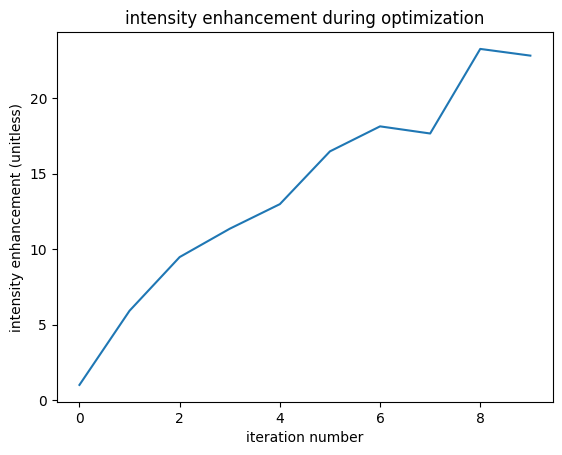

In [14]:
# objective function vs iteration number
plt.plot(objective_history)
plt.xlabel("iteration number")
plt.ylabel("intensity enhancement (unitless)")
plt.title("intensity enhancement during optimization")
plt.show()

In [15]:
# construct simulation with final parameters
sim_final = make_sim(param=param_history[-1])

# add a field monitor for plotting
fld_mnt = td.FieldMonitor(
    center=(+L/2 - buffer, 0, 0),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name="fields",
    colocate=False,
)
sim_final = sim_final.updated_copy(monitors=[fld_mnt])

# run simulation
data_final = tda.web.run_local(sim_final, task_name="quickstart_final", verbose=False)

In [16]:
# record final intensity
intensity_final = jnp.sum(jnp.array(data_final.get_intensity(monitor.name).values))
intensity_final_normalized = intensity_final / intensity_norm

objective_history.append(intensity_final_normalized)

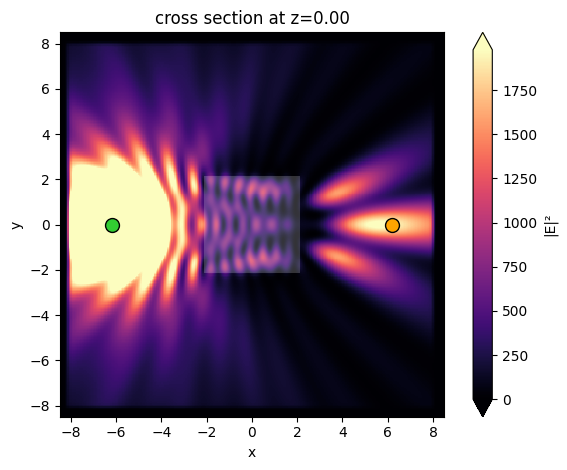

In [17]:
# plot intensity distribution
ax = data_final.plot_field(field_monitor_name="fields", field_name="E", val="abs^2", vmax=intensity_final)

ax.plot(source.center[0], 0, marker="o", mfc="limegreen", mec="black", ms=10)
ax.plot(monitor.center[0], 0, marker="o", mfc="orange", mec="black", ms=10)
plt.show()

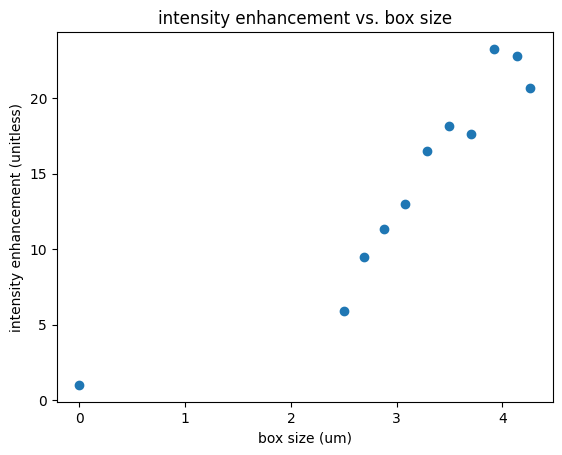

In [18]:
# scatter the intensity enhancement vs the box size
sizes = [get_size(p) for p in param_history]
objective_history = objective_history
_ = plt.scatter(sizes, objective_history)
ax = plt.gca()
ax.set_xlabel('box size (um)')
ax.set_ylabel('intensity enhancement (unitless)')
plt.title('intensity enhancement vs. box size')
plt.show()